In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_csv("airport_traffic_2024.csv")  # Upload to Colab or mount from Drive
df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'])
df = df.sort_values('FLT_DATE').reset_index(drop=True)
df.fillna(method='ffill', inplace=True)
df['FLT_TOT_1'] = df['FLT_TOT_1'].clip(lower=0)

# Add cyclical time features
df['DAY_OF_WEEK'] = df['FLT_DATE'].dt.dayofweek
df['MONTH'] = df['FLT_DATE'].dt.month
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# Features and target
features = [
    'FLT_DEP_1', 'FLT_ARR_1', 'FLT_TOT_1',
    'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2',
    'DAY_SIN', 'DAY_COS', 'MONTH_SIN', 'MONTH_COS'
]
target_column = 'FLT_TOT_1'

# Scale features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(df[[target_column]]).flatten()

# Clean
df_scaled_clean = df_scaled.dropna().reset_index(drop=True)
y_scaled_aligned = y_scaled[df_scaled_clean.index]


<ipython-input-44-e0e90351829e>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'])
<ipython-input-44-e0e90351829e>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


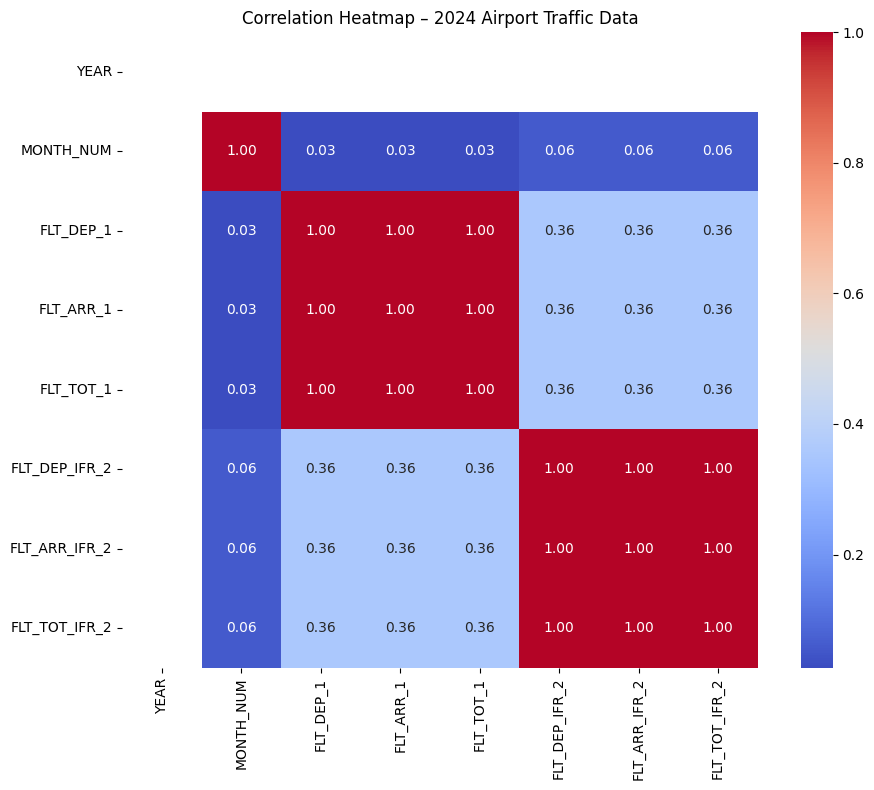

In [2]:
# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap – 2024 Airport Traffic Data")
plt.tight_layout()
plt.show()


In [45]:
SEQUENCE_LENGTH = 7

def create_sequences(data, target_array, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(target_array[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled_clean, y_scaled_aligned, SEQUENCE_LENGTH)
X = X.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))

# CNN layers
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fully connected
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 7, 64)          │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,601 (568.75 KB)

 Trainable params: 144,705 (565.25 KB)

 Non-trainable params: 896 (3.50 KB)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0098 - mae: 0.0910 - val_loss: 0.0116 - val_mae: 0.0967
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0099 - mae: 0.0910 - val_loss: 0.0116 - val_mae: 0.0943
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0098 - mae: 0.0908 - val_loss: 0.0115 - val_mae: 0.0961
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0100 - mae: 0.0921 - val_loss: 0.0116 - val_mae: 0.0958
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0096 - mae: 0.0899 - val_loss: 0.0115 - val_mae: 0.0960
Epoch 6/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0097 - mae: 0.0904 - val_loss: 0.0116 - val_mae: 0.0981
Epoch 7/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0098 - mae: 0.0907 - val_loss: 0.0115 - val_mae: 0.0951
Epoch 8/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0099 - mae: 0.0913 - val_loss: 0.0114 - val_mae: 0.1000
Epoch 9/100
1148/1148 ━━

In [49]:
# Predict
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
RMSE: 225.09
MAE: 140.13
R² Score: 0.0705


In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("airport_traffic_2024.csv")
df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'])
df = df.sort_values('FLT_DATE').reset_index(drop=True)
df.fillna(method='ffill', inplace=True)
df['FLT_TOT_1'] = df['FLT_TOT_1'].clip(lower=0)

# Time features
df['DAY_OF_WEEK'] = df['FLT_DATE'].dt.dayofweek
df['MONTH'] = df['FLT_DATE'].dt.month
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# Features and target
features = [
    'FLT_DEP_1', 'FLT_ARR_1', 'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2',
    'DAY_SIN', 'DAY_COS', 'MONTH_SIN', 'MONTH_COS'
]
target = 'FLT_TOT_1'

# Scale input and target
X = df[features]
y = df[[target]]

X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y).flatten()

# Combine for cleaning
X_df = pd.DataFrame(X_scaled, columns=features)
X_df['y'] = y_scaled

# Remove NaNs/Infs
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
X_df.dropna(inplace=True)

# Split clean features and target
X_clean = X_df[features].values
y_clean = X_df['y'].values

# Reshape for CNN input
X_cnn = X_clean.reshape(X_clean.shape[0], X_clean.shape[1], 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_clean, test_size=0.2, shuffle=False)


<ipython-input-53-fabbb38e35b8>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'])
<ipython-input-53-fabbb38e35b8>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 9, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,369 (196.75 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0361 - mae: 0.1121 - val_loss: 3.4560e-04 - val_mae: 0.0184
Epoch 2/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0012 - mae: 0.0306 - val_loss: 4.1820e-04 - val_mae: 0.0202
Epoch 3/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0010 - mae: 0.0272 - val_loss: 3.8195e-04 - val_mae: 0.0182
Epoch 4/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0010 - mae: 0.0267 - val_loss: 4.3975e-04 - val_mae: 0.0188
Epoch 5/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 9.3017e-04 - mae: 0.0255 - val_loss: 1.5101e-04 - val_mae: 0.0140
Epoch 6/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.6974e-04 - mae: 0.0244 - val_loss: 4.1378e-05 - val_mae: 0.0066
Epoch 7/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.3871e-04 - mae: 0.0239 - val_loss: 1.7522e-04 - val_mae: 0.0128
Epoch 8/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.6830e-04 - mae: 0.0228 - val_loss: 1.015

718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ CNN (No Sequence) Evaluation:
RMSE: 14.56
MAE: 9.73
R² Score: 0.9961


<ipython-input-56-ac62bd8dbb42>:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


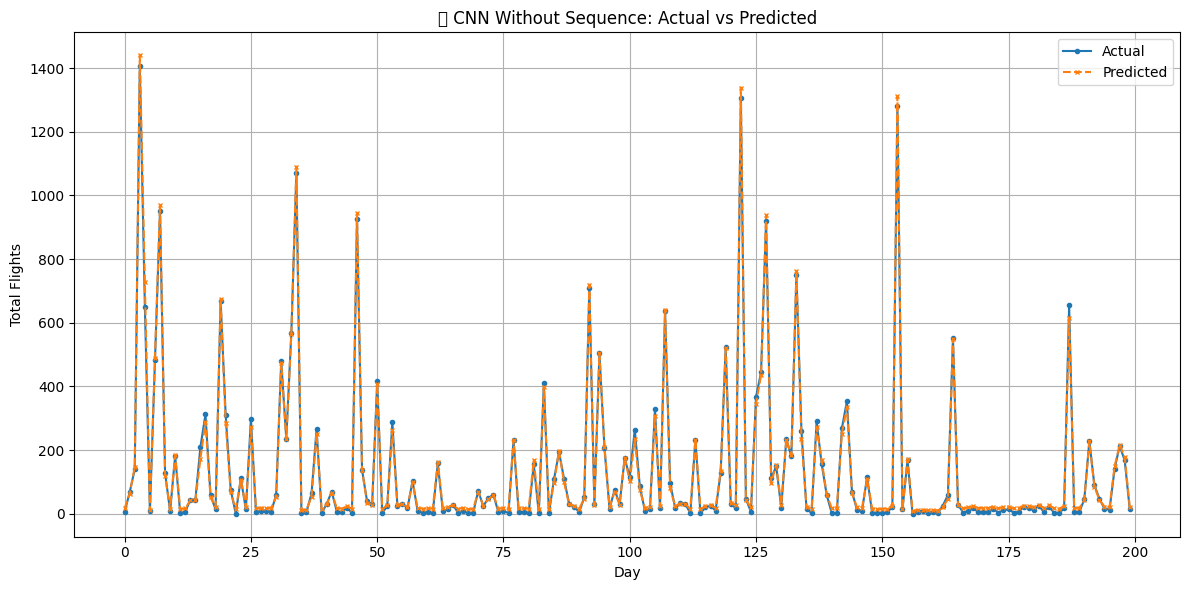

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("✅ CNN (No Sequence) Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_true[:200], label='Actual', marker='o', markersize=3)
plt.plot(y_pred[:200], label='Predicted', linestyle='--', marker='x', markersize=3)
plt.title("📊 CNN Without Sequence: Actual vs Predicted")
plt.xlabel("Day")
plt.ylabel("Total Flights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-57-ed27b9d03322>:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-57-ed27b9d03322>:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


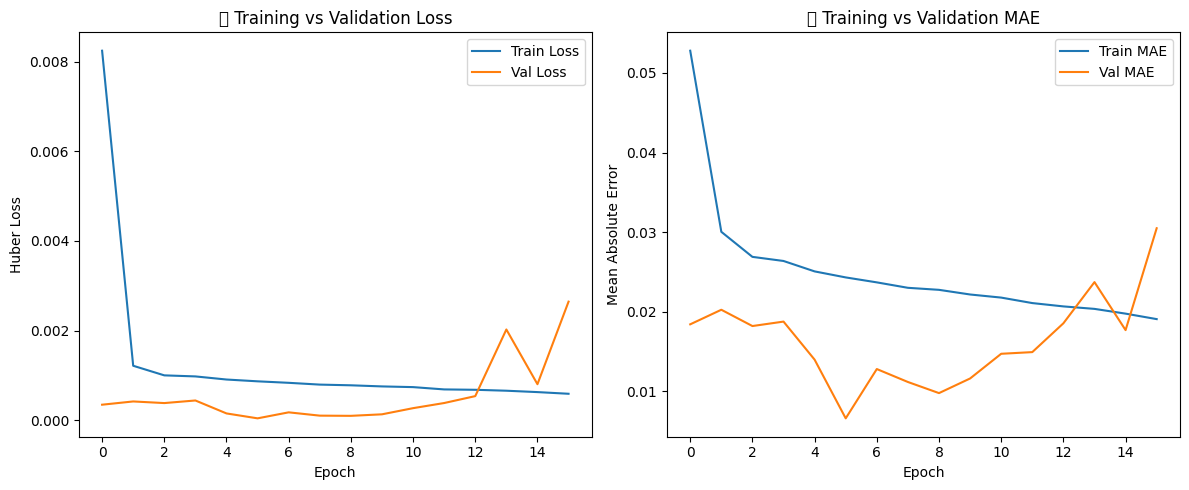

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Huber loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('📉 Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('📊 Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

model = Sequential()
model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))  # Stronger regularization

model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)  # Smaller LR
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 9, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 9, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 4, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,897 (50.38 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 192 (768.00 B)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1054 - mae: 0.2462 - val_loss: 0.0023 - val_mae: 0.0495
Epoch 2/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0033 - mae: 0.0510 - val_loss: 8.3646e-04 - val_mae: 0.0332
Epoch 3/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0024 - mae: 0.0426 - val_loss: 3.9782e-04 - val_mae: 0.0236
Epoch 4/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0020 - mae: 0.0389 - val_loss: 4.4216e-04 - val_mae: 0.0236
Epoch 5/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0020 - mae: 0.0377 - val_loss: 0.0011 - val_mae: 0.0291
Epoch 6/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0018 - mae: 0.0360 - val_loss: 1.6670e-04 - val_mae: 0.0151
Epoch 7/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0018 - mae: 0.0352 - val_loss: 1.3565e-04 - val_mae: 0.0129
Epoch 8/100
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0016 - mae: 0.0334 - val_loss: 2.0315e-04 - val_mae: 0.0170
Epoch 9

In [60]:
# Evaluation
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("✅ Optimized CNN (No Sequence) Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
✅ Optimized CNN (No Sequence) Evaluation:
RMSE: 25.24
MAE: 19.00
R² Score: 0.9883


<ipython-input-61-ed27b9d03322>:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-61-ed27b9d03322>:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


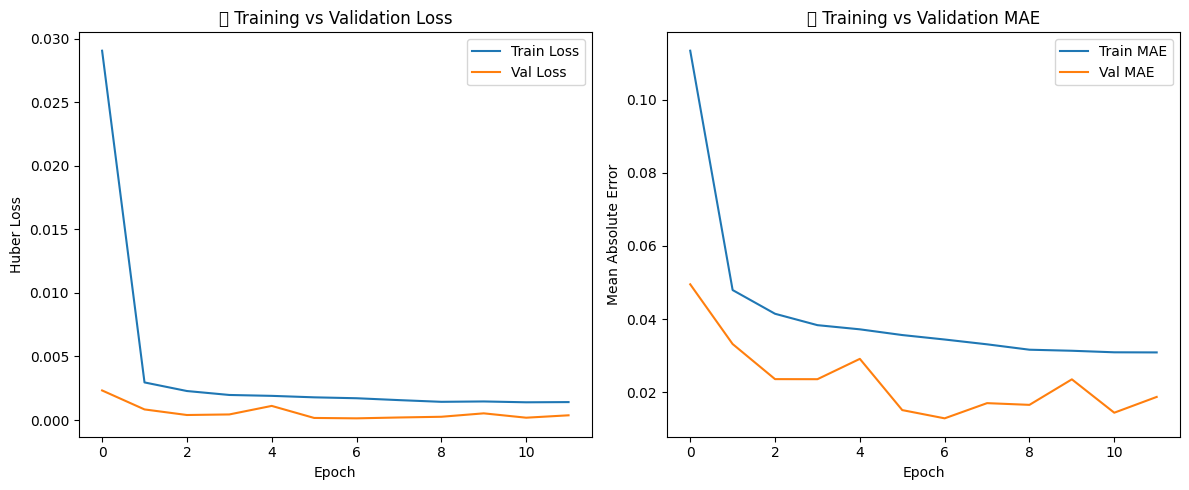

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Huber loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('📉 Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('📊 Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load & clean
df = pd.read_csv("airport_traffic_2024.csv")
df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'])
df = df.sort_values('FLT_DATE').reset_index(drop=True)
df.fillna(method='ffill', inplace=True)
df['FLT_TOT_1'] = df['FLT_TOT_1'].clip(lower=0)

# Time features
df['DAY_OF_WEEK'] = df['FLT_DATE'].dt.dayofweek
df['MONTH'] = df['FLT_DATE'].dt.month
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# Lag features
for lag in range(1, 6):
    df[f'FLT_TOT_1_LAG{lag}'] = df['FLT_TOT_1'].shift(lag)

# Rolling mean (optional, keeps from before)
df['FLT_TOT_1_ROLL3'] = df['FLT_TOT_1'].rolling(window=3).mean()

# Interaction features
df['DEPxARR'] = df['FLT_DEP_1'] * df['FLT_ARR_1']
df['IFR_DEPxARR'] = df['FLT_DEP_IFR_2'] * df['FLT_ARR_IFR_2']
df['IFR_TOTxLAG1'] = df['FLT_TOT_IFR_2'] * df['FLT_TOT_1_LAG1']

# Drop NaNs introduced by shifts
df.dropna(inplace=True)


<ipython-input-66-24ba223c9ffb>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'])
<ipython-input-66-24ba223c9ffb>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [67]:
features = [
    'FLT_DEP_1', 'FLT_ARR_1', 'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2',
    'DAY_SIN', 'DAY_COS', 'MONTH_SIN', 'MONTH_COS',
    'FLT_TOT_1_LAG1', 'FLT_TOT_1_LAG2', 'FLT_TOT_1_LAG3', 'FLT_TOT_1_LAG4', 'FLT_TOT_1_LAG5',
    'FLT_TOT_1_ROLL3',
    'DEPxARR', 'IFR_DEPxARR', 'IFR_TOTxLAG1'
]
target = 'FLT_TOT_1'

X = df[features]
y = df[[target]]

X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y).flatten()

X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_scaled, test_size=0.2, shuffle=False)


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

model = Sequential()
model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 18, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 18, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 9, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,633 (162.63 KB)

 Trainable params: 41,441 (161.88 KB)

 Non-trainable params: 192 (768.00 B)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0656 - mae: 0.1658 - val_loss: 4.2011e-04 - val_mae: 0.0228
Epoch 2/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0019 - mae: 0.0378 - val_loss: 2.5112e-04 - val_mae: 0.0181
Epoch 3/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0013 - mae: 0.0316 - val_loss: 1.1445e-04 - val_mae: 0.0100
Epoch 4/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0011 - mae: 0.0291 - val_loss: 1.6076e-04 - val_mae: 0.0127
Epoch 5/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0010 - mae: 0.0272 - val_loss: 1.5227e-04 - val_mae: 0.0133
Epoch 6/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.4676e-04 - mae: 0.0261 - val_loss: 9.8641e-05 - val_mae: 0.0104
Epoch 7/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.1969e-04 - mae: 0.0258 - val_loss: 8.8294e-05 - val_mae: 0.0097
Epoch 8/100
4590/4590 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 8.7710e-04 - mae: 0.0254 - val_loss: 1.3101e-0

718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Feature-Rich CNN Evaluation:
RMSE: 22.26
MAE: 14.60
R² Score: 0.9909


<ipython-input-70-c4b4b9931591>:35: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-70-c4b4b9931591>:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


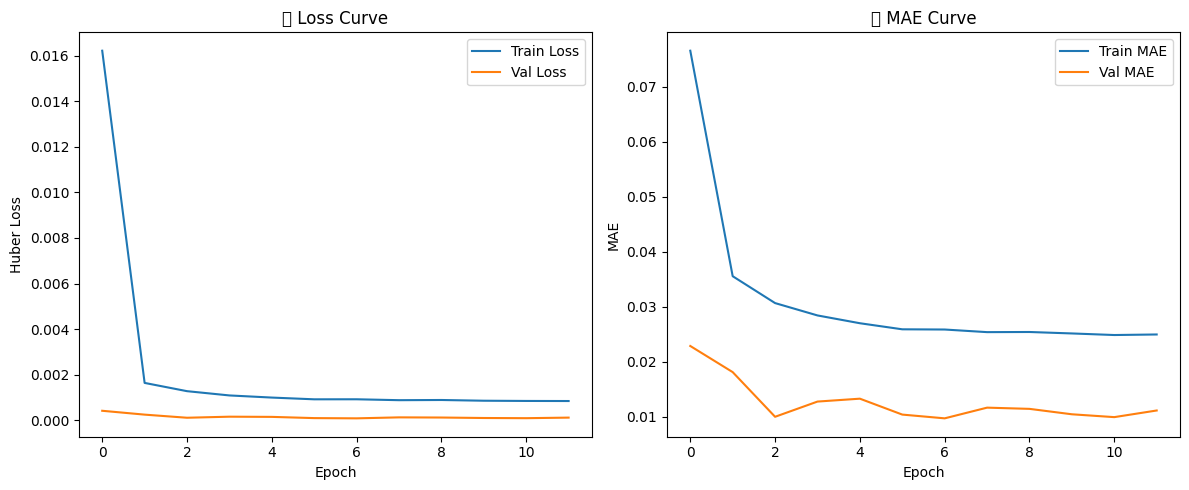

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("✅ Feature-Rich CNN Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot loss & MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('📉 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('📊 MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-71-a26aadd41032>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


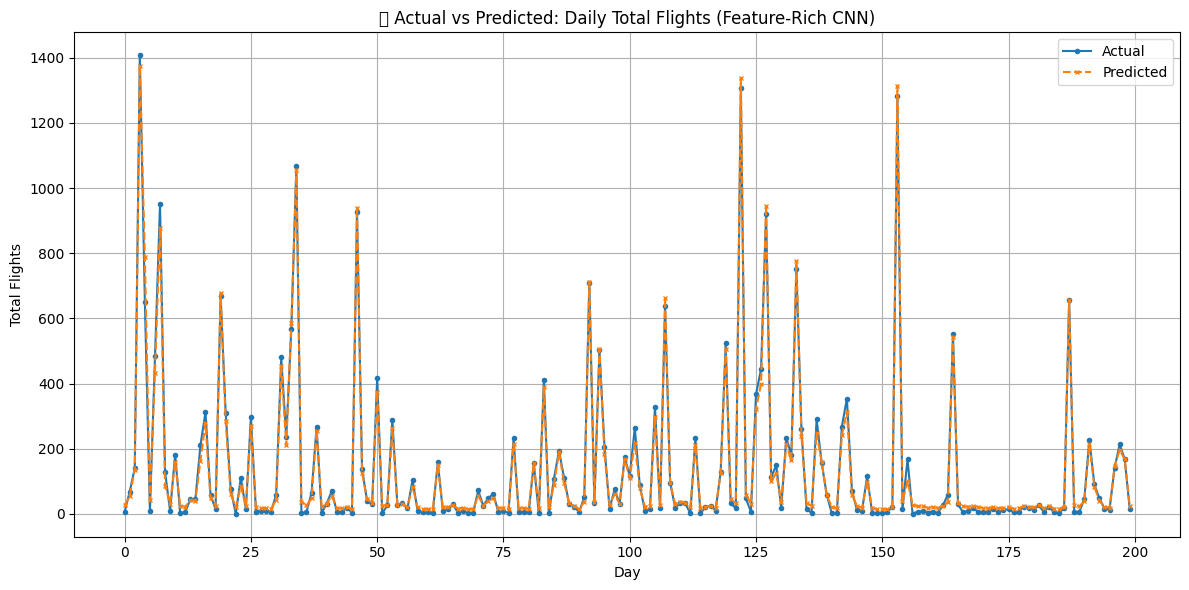

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true[:200], label='Actual', marker='o', markersize=3)
plt.plot(y_pred[:200], label='Predicted', linestyle='--', marker='x', markersize=3)
plt.title("📊 Actual vs Predicted: Daily Total Flights (Feature-Rich CNN)")
plt.xlabel("Day")
plt.ylabel("Total Flights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Adjusted LR decay
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# CNN model with more filters + tighter Huber
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))

# Use Huber with tighter delta
huber_loss = Huber(delta=0.5)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 18, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 9, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,329 (356.75 KB)

 Trainable params: 90,945 (355.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # slightly higher batch = more stable gradients
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0366 - mae: 0.1453 - val_loss: 5.8365e-04 - val_mae: 0.0256
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0019 - mae: 0.0377 - val_loss: 1.8168e-04 - val_mae: 0.0154
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0015 - mae: 0.0331 - val_loss: 1.8856e-04 - val_mae: 0.0156
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0014 - mae: 0.0316 - val_loss: 3.5530e-04 - val_mae: 0.0175
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0012 - mae: 0.0294 - val_loss: 3.0777e-04 - val_mae: 0.0169
Epoch 6/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0011 - mae: 0.0277 - val_loss: 9.8062e-05 - val_mae: 0.0110
Epoch 7/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0011 - mae: 0.0275 - val_loss: 2.8089e-04 - val_mae: 0.0174
Epoch 8/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0010 - mae: 0.0265 - val_loss: 1.1414e-04 - val_mae: 0.0123

718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Feature-Rich CNN Evaluation:
RMSE: 23.11
MAE: 17.46
R² Score: 0.9902


<ipython-input-74-c4b4b9931591>:35: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-74-c4b4b9931591>:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


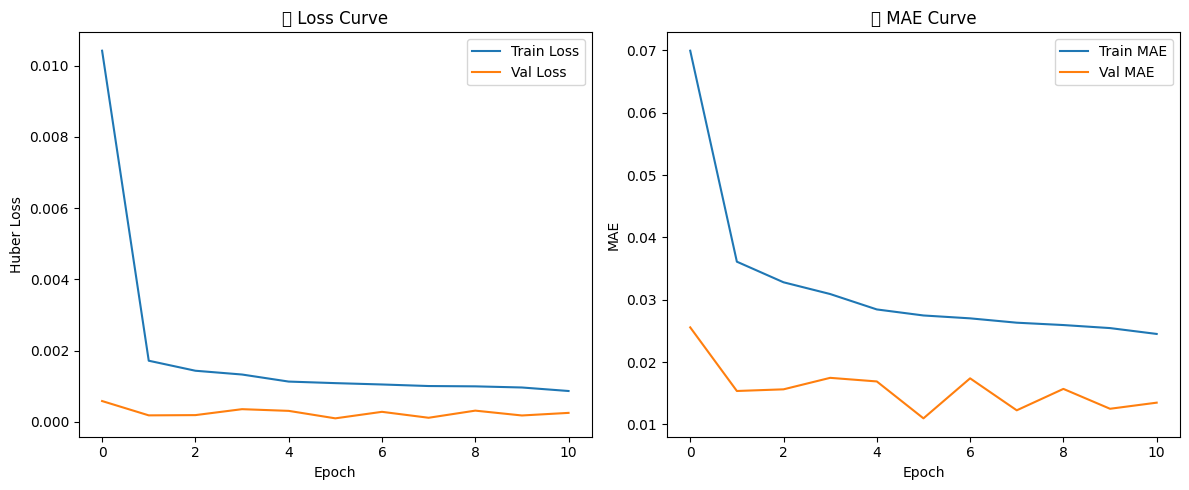

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("✅ Feature-Rich CNN Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot loss & MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('📉 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('📊 MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
